# Imports

In [1]:
from shared.simulators import ModeratedEffectSimulator, DataSimulator
from shared.ragged_analyzers import RaggedIPWAnalyzer, RaggedSIPWAnalyzer, RaggedMetaAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Create Simulated Data Set

In [2]:
# This section uses some functions from my simulation study to make a fake data set
# In practice, you'll have your own data and need to make sure it has a similar structure (see cells below)
N = 50
T = 100
effect_simulator = ModeratedEffectSimulator("Noisy Moderated Effects", N, 1., 1., 0.3, 1., 0.2, epsilon_sd=1.)
effect_simulator.sample_params()
data_simulator = DataSimulator(N, T).simulate_history()
data_simulator = data_simulator.simulate_effects(effect_simulator)
data_simulator = data_simulator.simulate_a()
ragged = False
if ragged:
    Ts = np.random.choice(np.arange(T//2, T), N)
else:
    Ts = np.array([T]*N)
T_total = Ts.sum().astype(int)
df = pd.DataFrame()
X = np.zeros((T_total, 2))
X_idx_start = 0
for i in range(N):
    T_i = Ts[i]
    X_idx_end = X_idx_start + T_i
    x = data_simulator.x[i, :T_i]
    X_i = np.ones((T_i, 2))
    X_i[:, 1] = x
    X[X_idx_start:X_idx_end] = X_i.copy()
    df_i = pd.DataFrame({
        "id": [i]*T_i,
        "a": data_simulator.a[i, :T_i],
        "p": data_simulator.p[i, :T_i],
        "y": data_simulator.y[i, :T_i]})
    df = pd.concat([df, df_i], axis=0)
    X_idx_start = X_idx_end
df = df.reset_index(drop=True)

In [3]:
# The data set you use should have at least the following columns (names may vary):
# User ID, treatment indicator, treatment assignment probability, outcome
df.head()

,id,a,p,y
0,0,True,0.445738,0.917141
1,0,False,0.674148,-3.191673
2,0,False,0.404605,-1.691779
3,0,True,0.464852,1.737700
4,0,False,0.541300,-4.214627


In [4]:
df.shape

(5000, 4)

In [5]:
# X is a design matrix with rows corresponding to df
X

array([[1.        , 0.56418574],
       [1.        , 2.45401538],
       [1.        , 0.2273746 ],
       ...,
       [1.        , 0.91165919],
       [1.        , 1.65778115],
       [1.        , 1.68343027]], shape=(5000, 2))

In [6]:
X.shape

(5000, 2)

# Fit Model

In [7]:
# You can toggle the robust and dr options
robust = True
dr = False

# Specify the correct column names for the subject ID, treatment, treatment assignment probability, and outcome
ragged_analyzer = RaggedIPWAnalyzer(id_col="id", treatment_col="a", prob_col="p", outcome_col="y", dr=dr, robust=robust)
ragged_analyzer = ragged_analyzer.fit(df, X)  # Fit to data

In [8]:
# Look at estimated effects and standard errors for first 3 users
# The first entry is an intercept and the second is a slope corresponding to x
# These are effectively causal excursion effects for each user
print(ragged_analyzer.estimates[:3])
print(ragged_analyzer.estimates_se[:3])

[[2.81453188 1.23800244]
 [3.51830662 0.73534775]
 [3.87480551 0.376229  ]]
[[0.53190847 0.48065246]
 [0.57138246 0.43333245]
 [0.57085308 0.41765712]]


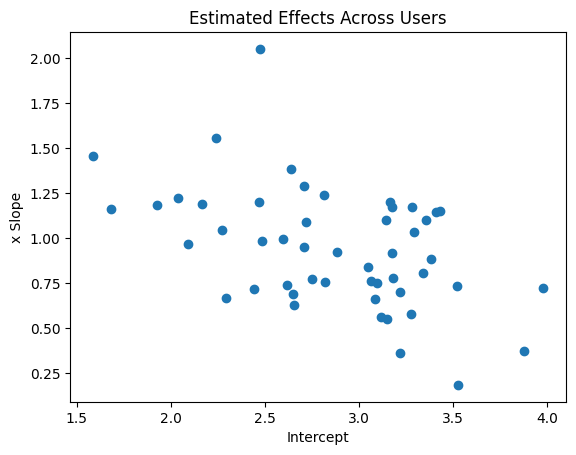

In [9]:
# Plot the estimates
plt.scatter(ragged_analyzer.estimates[:, 0], ragged_analyzer.estimates[:, 1])
plt.xlabel("Intercept")
plt.ylabel("x Slope")
plt.title("Estimated Effects Across Users")
plt.show()

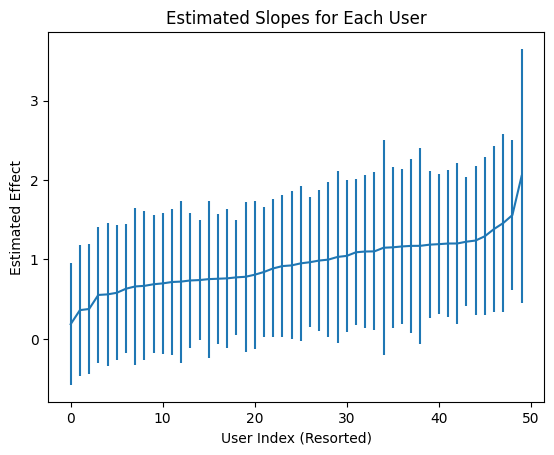

In [10]:
# Plot the slopes with error bars
idx_sorted = np.argsort(ragged_analyzer.estimates[:, 1])
plt.errorbar(
    x=np.arange(N),
    y=ragged_analyzer.estimates[idx_sorted, 1],
    yerr=1.96 * ragged_analyzer.estimates_se[idx_sorted, 1])
plt.xlabel("User Index (Resorted)")
plt.ylabel("Estimated Effect")
plt.title("Estimated Slopes for Each User")
plt.show()

In [11]:
# You can also access the joint covariance matrix for the regression coefficients
# NOTE: The estimates are independent across users
print(ragged_analyzer.estimates_cov[:3])

[[[ 0.28292662 -0.11642594]
  [-0.11642594  0.23102679]]

 [[ 0.32647792 -0.14203229]
  [-0.14203229  0.18777701]]

 [[ 0.32587324 -0.12560614]
  [-0.12560614  0.17443747]]]


In [12]:
# You can also fit a meta-analysis model
ragged_meta_analyzer = RaggedMetaAnalyzer(ragged_analyzer, name="Meta")
ragged_meta_analyzer = ragged_meta_analyzer.fit(df, X)

In [13]:
# Average effects across users: mean and covariance matrix
print(ragged_meta_analyzer.mean)
print(ragged_meta_analyzer.mean_cov)

[2.86400367 0.94268424]
[[ 0.0073402  -0.00359651]
 [-0.00359651  0.00476957]]


In [14]:
# Estimated covariance matrix for random effects
print(ragged_meta_analyzer.re_cov)

[[0.1 0. ]
 [0.  0.1]]


# Extra

You can also try out the RaggedSIPWAnalyzer as an alternative to RaggedIPWAnalyzer. The former normalizes the inverse probability weights, which can (but is not guaranteed to) result in higher precision.

If you only want inference at the aggregate level, just pass the same ID for everyone. If you have no variability in treatment assignments or outcomes at the user level, then you will probably need to do this (or perform some other sort of grouping).

Instead of using the built-in meta-analysis method (which assumes Gaussian random effects), you're welcome to plug the estimates and their standard errors directly into your favorite meta-analysis model.